#Importing

In [ ]:
import numpy as np
import cv2
from skimage import io, util
import heapq

In [1]:
from google.colab.patches import cv2_imshow


#SSD error calculation

In [97]:
def SSD(patch, patchLength, overlap, res, i, j):
  error = 0
  if i > 0:
    dif   = patch[:overlap, :] - res[i:i+overlap, j:j+patchLength]
    error += np.sum(dif**2)

  if j > 0:
    dif = patch[:, :overlap] - res[i:i+patchLength, j:j+overlap]
    error += np.sum(dif**2)

  if j > 0 and i > 0:
    dif = patch[:overlap, :overlap] - res[i:i+overlap, j:j+overlap]
    error -= np.sum(dif**2)

  return error

#Best patch choosing

First, we randomly choose one patch from our texture based on the calculated SSD error.

In [98]:
def Best_SSD(texture, patchLength, overlap, res, ip, jp):
  h, w = texture[:, :, 0].shape
  full_Error = np.zeros((h - patchLength, w - patchLength))

  for i in range(h - patchLength):
    for j in range(w - patchLength):
        patch = texture[i:i+patchLength, j:j+patchLength]
        error = SSD(patch, patchLength, overlap, res, ip, jp)
        full_Error[i, j] = error

  ind = np.where(full_Error == np.argmin(full_Error))
  i = ind[0][0]
  j = ind[1][0]

  return texture[i:i+patchLength, j:j+patchLength]

#Min cut algorithm

Now using min cut algorithm, we should compute where to put the best patch. we use dijkstra algorithm.We assume each (i, j) as a node. the value of this node is as same as its calculated SSD error. so for each flow we should add these related errors to each other.
we examine each path(we build a queue from the first nodes and then walk through all of the nodes and add errors) and its error. after that we return the path with min error flow.

In [99]:
def minCutPath(errors):
  pq = [(error, [i]) for i, error in enumerate(errors[0])]
  heapq.heapify(pq)
  h, w = errors.shape
  seen = set()

  while pq:
    error, path = heapq.heappop(pq)
    curDepth = len(path)
    curIndex = path[-1]

    if curDepth == h:
        return path

    for delta in -1, 0, 1:
        nextIndex = curIndex + delta

        if 0 <= nextIndex < w:
            if (curDepth, nextIndex) not in seen:
                cumError = error + errors[curDepth, nextIndex]
                heapq.heappush(pq, (cumError, path + [nextIndex]))
                seen.add((curDepth, nextIndex))

for each i and j we calculate the SSD error of the selected patch. using this error matrix as a graph we run the min cut on it.

In [100]:
def minCutPatch(patch, patchLength, overlap, res, ip, jp):
    patch = patch.copy()
    h_patch, w_patch = patch[:, :, 0].shape
    minCut = np.zeros_like(patch, dtype=bool)

    if jp > 0:
        dif = patch[:, :overlap] - res[ip:ip+h_patch, jp:jp+overlap]
        difSSD = np.sum(dif**2, axis=2)
        for i, j in enumerate(minCutPath(difSSD)):
            minCut[i, :j] = True

    if ip > 0:
        dif = patch[:overlap, :] - res[ip:ip+overlap, jp:jp+w_patch]
        difSSD = np.sum(dif**2, axis=2)
        for j, i in enumerate(minCutPath(difSSD.T)):
            minCut[:i, j] = True

    np.copyto(patch, res[ip:ip+h_patch, jp:jp+w_patch], where=minCut)

    return patch

#Hole filling

In [101]:
def hole_filling(texture, patchLength, numPatches):
    texture = util.img_as_float(texture)

    #defining the allowed value of overlap:
    overlap = patchLength // 6
    numPatchesHigh, numPatchesWide = numPatches

    h = (numPatchesHigh * patchLength) - (numPatchesHigh - 1) * overlap
    w = (numPatchesWide * patchLength) - (numPatchesWide - 1) * overlap

    res = np.zeros((h, w, texture.shape[2]))

    for i in range(numPatchesHigh):
        for j in range(numPatchesWide):
            y = i * (patchLength - overlap)
            x = j * (patchLength - overlap)

            if (i == 0 and j == 0):
                H, W = texture[:, :, 0].shape
                a = np.random.randint(H - patchLength)
                b = np.random.randint(W - patchLength)
                patch = texture[a:a+patchLength, b:b+patchLength]
            else:
                patch = Best_SSD(texture, patchLength, overlap, res, y, x)
                patch = minCutPatch(patch, patchLength, overlap, res, y, x)

            res[y:y+patchLength, x:x+patchLength] = patch

    return res

#running the algorithm

##swimmer

Now we should find all black rectangles. to do this, we transfer the image to gray scale, after that we binerize it.(black region = 0, other regions = 255), we find rectangles using boundRect function.

In [177]:
img = cv2.imread('/content/Swimmer_b.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#binary = cv2.bitwise_not(gray)
binary = gray
for i in range(binary.shape[0]):
  for j in range(binary.shape[1]):
    if(binary[i, j]!=0):
      binary[i, j] = 255
#cv2_imshow(~binary)

In [ ]:
points = cv2.findNonZero(~binary)
(x,y,w,h) = cv2.boundingRect(points)
cv2.rectangle(img, (x,y), (x+w,y+h), (0,255,0), 2)

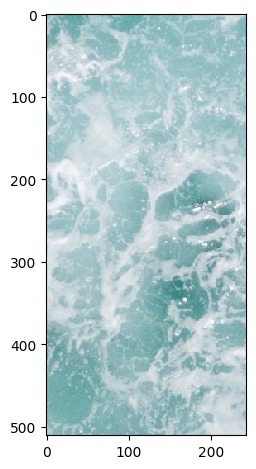

In [179]:
img0 = io.imread('/content/Swimmer_b.jpg')
texture = img0[x:x+h, y-w:y, :]
io.imshow(texture)
io.show()

In [180]:
res = hole_filling(texture, 100, (6, 3))

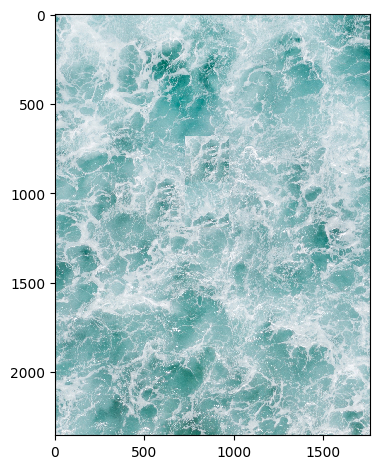

In [181]:
#transfering res from foalt64 to unit8:
res = 255 * res
res = res.astype(np.uint8)
IMG = img0.copy()
IMG[y:y+h, x:x+w, :] = res[0:h, 0:w, :]
io.imshow(IMG)
io.show()

In [182]:
io.imsave('/content/Swimmer_b_res.jpg', IMG)

##Eagle

P.S = i tried to detect all of the rectangles using the same algorithm for binerizing the image in "swimmer" part. and with the aid of cv2.findContour function but the holes were detected wrongly. so i gave the algorithm the approximate positions of the rectangles as below:

In [166]:
#approximate positions:
y = np.array([561, 879, 733, 700, 4056, 3761, 3210])
x = np.array([429, 888, 1527, 1908, 1682, 1539, 1244])
h = 218
w = 92

now we run the same algorithm discussed above for each rectangle.Like before each time we choose the left part of the rectangle as our texture.Here our hyperparameter is the patch Lengrh, which we should choose based on the dimensions of our texture. instead of 100 in the previous image we choose this lengh 50 here with respect to the h and w of texture. because it is obvious that the length should not be greater than texture's dimension.

In [174]:
img0 = io.imread('/content/HainesEagle_b.jpg')
IMG = img0.copy()
for i in range(len(x)):
  texture = img0[x[i]:x[i]+h, y[i]-w:y[i], :]
  res = hole_filling(texture, 50, (6, 4))
  res = 255 * res
  res = res.astype(np.uint8)
  IMG[x[i]:x[i]+h, y[i]:y[i]+w, :] = res[0:h, 0:w, :]

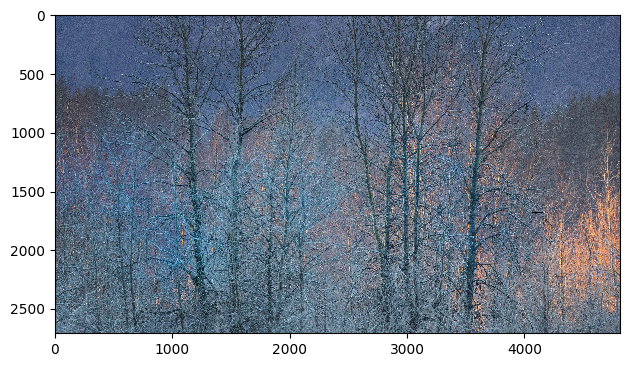

In [171]:
io.imshow(IMG)
io.show()

In [175]:
io.imsave('/content/HainesEagle_b_res.jpg', IMG)